In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import copy
from sklearn.utils.class_weight import compute_class_weight

from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [20]:
df_test = pd.read_csv(r"D:\yousef\Master\ML\project\models\k_fold_models\data_final_v\test.csv")
df_train = pd.read_csv(r"D:\yousef\Master\ML\project\models\k_fold_models\data_final_v\train.csv")


In [5]:
print(df_test["label_encoded"].value_counts(dropna=False))
print(df_test["label_encoded"].unique())
print(df_train["label_encoded"].value_counts(dropna=False))
print(df_train["label_encoded"].unique())


label_encoded
4     24274
9     19784
0     19566
8      9875
10     5702
3      2947
11     1786
1       734
2       669
7       543
5       248
6       137
12       10
Name: count, dtype: int64
[ 9  4  0 10 11  8  3  7  1  5  6  2 12]
label_encoded
4     97094
9     79133
0     78265
8     39498
10    22808
3     11788
11     7141
1      2935
2      2677
7      2174
5       994
6       548
12       41
Name: count, dtype: int64
[ 4  3  8  9  0 10  6 11  1  2  5  7 12]


In [21]:
X_train = df_train.drop(columns=['label','label_encoded'
])
y_train = df_train['label_encoded']
X_test = df_test.drop(columns=['label','label_encoded'
])
y_test = df_test['label_encoded']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, stratify=y_train, random_state=42
)





In [22]:
def evaluate_model(model, X, y, plot_cm=True, class_names=None):
    model.eval()

    if hasattr(X, "values"):
        X = X.values
    if hasattr(y, "values"):
        y = y.values

    X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1).to(device)

    with torch.no_grad():
        outputs = model(X_tensor)
        y_pred = torch.argmax(outputs, dim=1).cpu().numpy()

    acc = accuracy_score(y, y_pred)
    f1_weighted = f1_score(y, y_pred, average='weighted')
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1_per_class = f1_score(y, y_pred, average=None)
    cm = confusion_matrix(y, y_pred)

    print("Confusion Matrix:")
    print(cm)

    print(f"\nAccuracy        : {acc:.4f}")
    print(f"Weighted F1     : {f1_weighted:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall   : {recall:.4f}")

    print("\nF1-score per class:")
    for i, f1 in enumerate(f1_per_class):
        label = class_names[i] if class_names is not None else i
        print(f"Class {label}: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(
        y, y_pred,
        target_names=class_names,
        digits=4
    ))

    if plot_cm:
        plt.figure(figsize=(9,7))
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names
        )
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()

    metrics = {
        "accuracy": acc,
        "f1_weighted": f1_weighted,
        "precision_weighted": precision,
        "recall_weighted": recall,
        "f1_per_class": f1_per_class
    }

    return metrics, cm


In [23]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_classes=13):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(hidden_size * 2, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)  
        )

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        return self.fc(x)


In [ ]:


def Training(
    X_train, y_train,
    X_val, y_val,
    patience=10,
    num_classes=13,
    batch_size=64,
    epochs=100
):

    if hasattr(X_train, "values"):
        
        X_train = X_train.values
        X_val   = X_val.values

    if hasattr(y_train, "values"):
        y_train = y_train.values
        y_val   = y_val.values

    # Compute CLASS WEIGHTS 
    classes = np.arange(num_classes)  
    weights = compute_class_weight(
        class_weight="balanced",
        classes=classes,
        y=y_train
    )
    class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    y_train = torch.tensor(y_train, dtype=torch.long)

    X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
    y_val = torch.tensor(y_val, dtype=torch.long)

    train_loader = DataLoader(
        TensorDataset(X_train, y_train),
        batch_size=batch_size,
        shuffle=True
    )

    val_loader = DataLoader(
        TensorDataset(X_val, y_val),
        batch_size=batch_size,
        shuffle=False
    )

    model = BiLSTM(
        input_size=X_train.shape[2],
        num_classes=num_classes
    ).to(device)

    #  Weighted Loss 
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    best_loss = float("inf")
    best_weights = None
    patience_counter = 0

    #  Training Loop 
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        #  Validation 
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        print(
            f"Epoch {epoch+1:03d} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f}"
        )

        #  Early stopping 
        if val_loss < best_loss:
            best_loss = val_loss
            best_weights = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    model.load_state_dict(best_weights)
    return model


Epoch 1 | Train Loss: 2.5912 | Val Loss: 2.5727
Epoch 2 | Train Loss: 2.5733 | Val Loss: 2.5546
Epoch 3 | Train Loss: 2.5556 | Val Loss: 2.5369
Epoch 4 | Train Loss: 2.5380 | Val Loss: 2.5189
Epoch 5 | Train Loss: 2.5202 | Val Loss: 2.5007
Epoch 6 | Train Loss: 2.5021 | Val Loss: 2.4822
Epoch 7 | Train Loss: 2.4839 | Val Loss: 2.4633
Epoch 8 | Train Loss: 2.4651 | Val Loss: 2.4440
Epoch 9 | Train Loss: 2.4456 | Val Loss: 2.4238
Epoch 10 | Train Loss: 2.4255 | Val Loss: 2.4028
Epoch 11 | Train Loss: 2.4044 | Val Loss: 2.3807
Epoch 12 | Train Loss: 2.3823 | Val Loss: 2.3575
Epoch 13 | Train Loss: 2.3589 | Val Loss: 2.3329
Epoch 14 | Train Loss: 2.3341 | Val Loss: 2.3068
Epoch 15 | Train Loss: 2.3080 | Val Loss: 2.2790
Epoch 16 | Train Loss: 2.2799 | Val Loss: 2.2495
Epoch 17 | Train Loss: 2.2504 | Val Loss: 2.2180
Epoch 18 | Train Loss: 2.2188 | Val Loss: 2.1846
Epoch 19 | Train Loss: 2.1854 | Val Loss: 2.1489
Epoch 20 | Train Loss: 2.1497 | Val Loss: 2.1110
Epoch 21 | Train Loss: 2.1118

c:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[23096     0     0     3    30     0     0     0   350     0     0     1
      0]
 [   62     0     0   689    92     0     0     0     0    38     0     0
      0]
 [    1     0     0   763     0     0     0     0     1    38     0     0
      0]
 [    2     0     0  2633   340     0     0     0     0   561     0     0
      0]
 [  115     0     0    69 28927     0     0     0     8     9     0     0
      0]
 [    4     0     0    86   200     0     0     0     1     7     0     0
      0]
 [   11     0     0    28   106     0     0     0    17     2     0     0
      0]
 [    2     0     0   607    16     0     0     0     0    27     0     0
      0]
 [   83     0     0     8    11     0     0     0 11748     0     0     0
      0]
 [   36     0     0    17    52     0     0     0    42 23593     0     0
      0]
 [    1     0     0   233  6574     0     0     0     2    33     0     0
      0]
 [   19     0     0    33   512     0     0     0  1577     1     0  

c:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


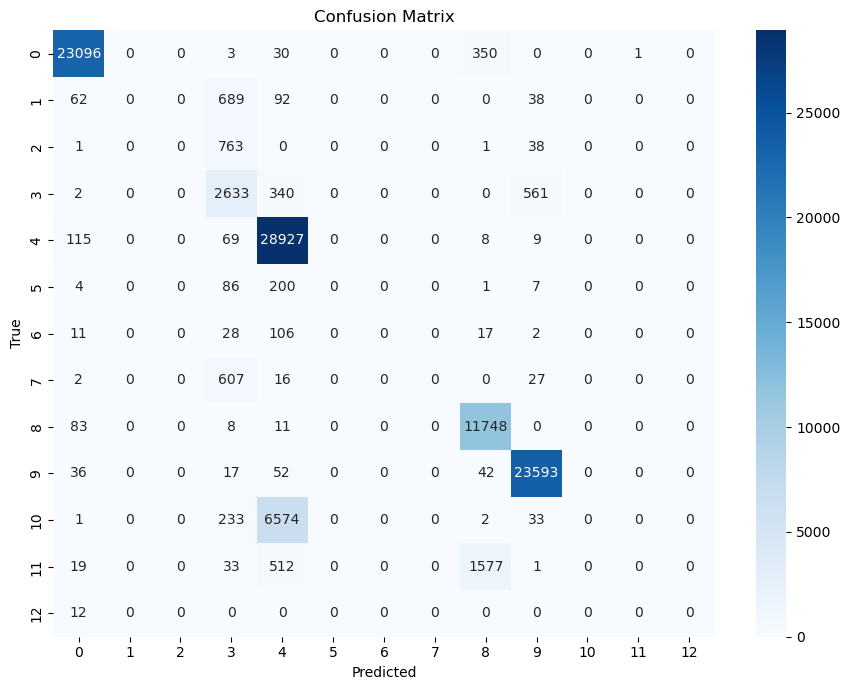

c:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[19227     0     0     2    30     0     0     0   304     0     0     3
      0]
 [   41     0     0   571    86     0     0     0     0    36     0     0
      0]
 [    2     0     0   650     0     0     0     0     0    17     0     0
      0]
 [    1     0     0  2193   292     0     0     0     0   461     0     0
      0]
 [   85     0     0    73 24098     0     0     0     4    14     0     0
      0]
 [    1     0     0    75   166     0     0     0     1     5     0     0
      0]
 [   17     0     0    16    90     0     0     0    13     1     0     0
      0]
 [    0     0     0   502    17     0     0     0     0    24     0     0
      0]
 [   49     0     0     7     9     0     0     0  9810     0     0     0
      0]
 [   26     0     0    19    33     0     0     0    45 19661     0     0
      0]
 [    2     0     0   187  5493     0     0     0     1    19     0     0
      0]
 [   18     0     0    24   422     0     0     0  1321     1     0  

c:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


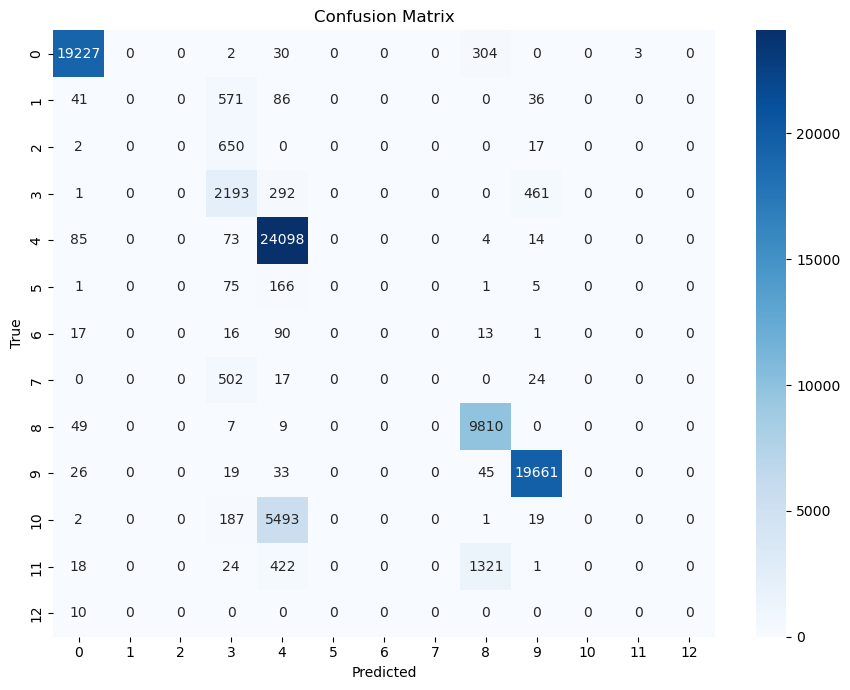

({'accuracy': 0.8691857432628224,
  'f1_weighted': 0.820841345595077,
  'precision_weighted': 0.7822005285894875,
  'recall_weighted': 0.8691857432628224,
  'f1_per_class': array([0.98486362, 0.        , 0.        , 0.60363336, 0.87613161,
         0.        , 0.        , 0.        , 0.91793768, 0.98248507,
         0.        , 0.        , 0.        ])},
 array([[19227,     0,     0,     2,    30,     0,     0,     0,   304,
             0,     0,     3,     0],
        [   41,     0,     0,   571,    86,     0,     0,     0,     0,
            36,     0,     0,     0],
        [    2,     0,     0,   650,     0,     0,     0,     0,     0,
            17,     0,     0,     0],
        [    1,     0,     0,  2193,   292,     0,     0,     0,     0,
           461,     0,     0,     0],
        [   85,     0,     0,    73, 24098,     0,     0,     0,     4,
            14,     0,     0,     0],
        [    1,     0,     0,    75,   166,     0,     0,     0,     1,
             5,     0

In [ ]:
class_names = [str(i) for i in range(13)]  

bilstm_model = Training(
    X_train, y_train,
    X_val, y_val,
    num_classes=13
)

torch.save(
    bilstm_model.state_dict(),
    r"D:\yousef\Master\ML\project\models\multiclass_models\bilstm_base.pt"
)

evaluate_model(bilstm_model, X_val, y_val, class_names=class_names)
evaluate_model(bilstm_model, X_test, y_test, class_names=class_names)


Epoch 001 | Train Loss: 0.7847 | Val Loss: 0.6541
Epoch 002 | Train Loss: 0.6409 | Val Loss: 0.6097
Epoch 003 | Train Loss: 0.6068 | Val Loss: 0.6024
Epoch 004 | Train Loss: 0.5873 | Val Loss: 0.5774
Epoch 005 | Train Loss: 0.5676 | Val Loss: 0.5717
Epoch 006 | Train Loss: 0.5620 | Val Loss: 0.5641
Epoch 007 | Train Loss: 0.5570 | Val Loss: 0.5475
Epoch 008 | Train Loss: 0.5523 | Val Loss: 0.5515
Epoch 009 | Train Loss: 0.5499 | Val Loss: 0.5376
Epoch 010 | Train Loss: 0.5443 | Val Loss: 0.5529
Epoch 011 | Train Loss: 0.5422 | Val Loss: 0.5445
Epoch 012 | Train Loss: 0.5411 | Val Loss: 0.5358
Epoch 013 | Train Loss: 0.5381 | Val Loss: 0.5465
Epoch 014 | Train Loss: 0.5411 | Val Loss: 0.5492
Epoch 015 | Train Loss: 0.5347 | Val Loss: 0.5531
Epoch 016 | Train Loss: 0.5357 | Val Loss: 0.5416
Epoch 017 | Train Loss: 0.5356 | Val Loss: 0.5391
Epoch 018 | Train Loss: 0.5397 | Val Loss: 0.5503
Epoch 019 | Train Loss: 0.5339 | Val Loss: 0.5508
Epoch 020 | Train Loss: 0.5305 | Val Loss: 0.5359


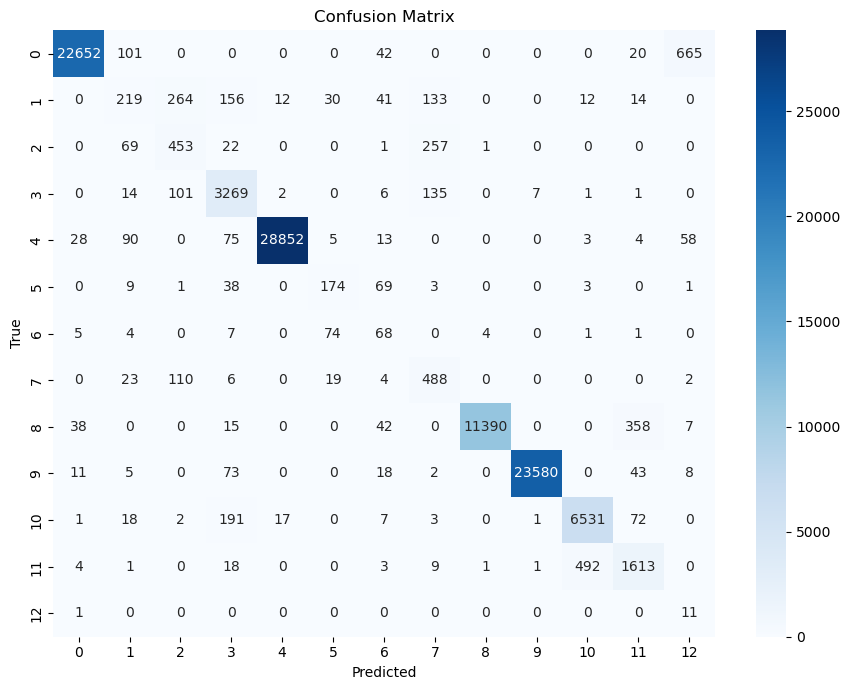

Confusion Matrix:
[[18848    80     0     0     0     1    36     0     0     0     0    19
    582]
 [    2   160   205   153     8    31    38   113     0     0    13    11
      0]
 [    1    52   378    10     0     0     0   228     0     0     0     0
      0]
 [    1     7    66  2751     8     0     7   103     0     2     1     1
      0]
 [   16    77     1    50 24050     4    17     0     0     1     2     6
     50]
 [    0     5     2    28     0   153    54     1     0     0     5     0
      0]
 [   10     1     0     6     0    60    59     0     0     0     0     0
      1]
 [    0    18    86     3     0    18     5   413     0     0     0     0
      0]
 [   28     3     0     7     0     0    27     0  9522     0     0   281
      7]
 [    8     3     0    63     0     0    14     3     0 19637     2    46
      8]
 [    1    13     0   176    11     1     7     1     0     0  5438    54
      0]
 [    4     1     2    15     0     0     3     7     0     0   400  

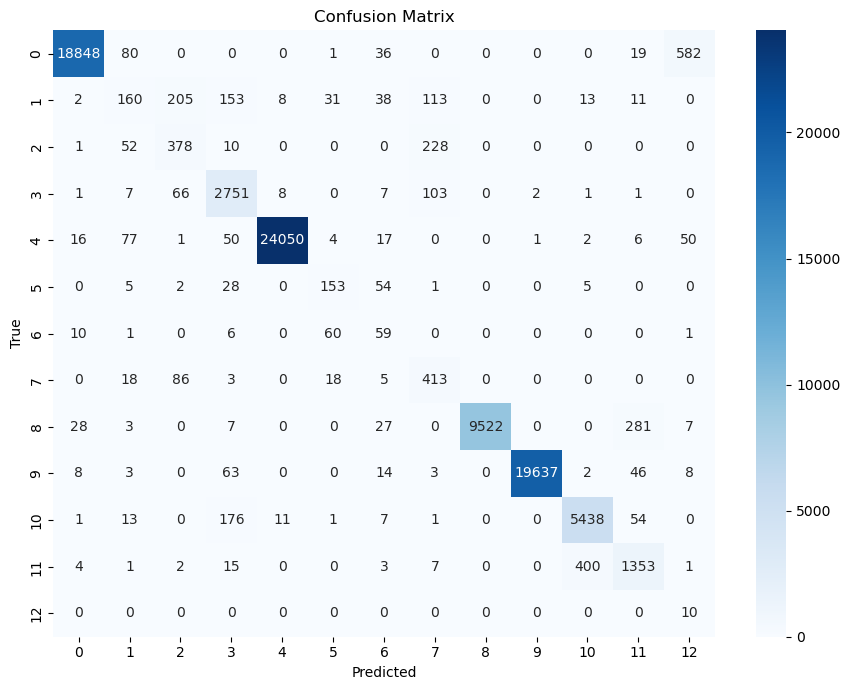

({'accuracy': 0.95939727615184,
  'f1_weighted': 0.963404837563827,
  'precision_weighted': 0.9688442049449248,
  'recall_weighted': 0.95939727615184,
  'f1_per_class': array([0.97949851, 0.27729636, 0.53655075, 0.88613303, 0.99480879,
         0.59302326, 0.29207921, 0.58498584, 0.98180131, 0.99619521,
         0.94058635, 0.76075344, 0.02989537])},
 array([[18848,    80,     0,     0,     0,     1,    36,     0,     0,
             0,     0,    19,   582],
        [    2,   160,   205,   153,     8,    31,    38,   113,     0,
             0,    13,    11,     0],
        [    1,    52,   378,    10,     0,     0,     0,   228,     0,
             0,     0,     0,     0],
        [    1,     7,    66,  2751,     8,     0,     7,   103,     0,
             2,     1,     1,     0],
        [   16,    77,     1,    50, 24050,     4,    17,     0,     0,
             1,     2,     6,    50],
        [    0,     5,     2,    28,     0,   153,    54,     1,     0,
             0,     5,   

In [35]:
class_names = [str(i) for i in range(13)]  # or real attack names

bilstm_model = Training(
    X_train, y_train,
    X_val, y_val,
    num_classes=13
)

torch.save(
    bilstm_model.state_dict(),
    r"D:\yousef\Master\ML\project\models\multiclass_models\bilstm_weighted.pt"
)

evaluate_model(bilstm_model, X_val, y_val, class_names=class_names)
evaluate_model(bilstm_model, X_test, y_test, class_names=class_names)


In [ ]:
def predict_bilstm(model, X):
    model.eval()

    if hasattr(X, "values"):
        X = X.values

    X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1).to(device)

    with torch.no_grad():
        outputs = model(X_tensor)          # shape: [N, 13]
        y_pred = torch.argmax(outputs, dim=1).cpu().numpy()

    return y_pred


In [42]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bilstm_model.load_state_dict(
    torch.load(
        r"D:\yousef\Master\ML\project\models\multiclass_models\bilstm_weighted.pt",
        map_location=device
    )
)
y_predict=predict_bilstm(bilstm_model, X_test)



In [43]:
print(y_predict)

[ 9  4  4 ...  9 10  9]


K_fold


In [ ]:
def Training(
    model,
    X_train, y_train,
    X_val, y_val,
    epochs=100,
    lr=1e-3,
    patience=10,
    batch_size=64,
    num_classes=13
):
    train_losses, val_losses = [], []

    # ===== NumPy =====
    if hasattr(X_train, "values"):
        X_train, X_val = X_train.values, X_val.values
    if hasattr(y_train, "values"):
        y_train, y_val = y_train.values, y_val.values

    # ===== SAFE CLASS WEIGHTS =====
    unique_classes = np.unique(y_train)

    weights = compute_class_weight(
        class_weight="balanced",
        classes=unique_classes,
        y=y_train
    )

    class_weights = torch.zeros(num_classes, device=device)
    class_weights[unique_classes] = torch.tensor(
        weights, dtype=torch.float32, device=device
    )

    # ===== Tensors =====
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  #  add seq_len dim
    X_val   = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1) 
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.long)

    train_ds = TensorDataset(X_train, y_train)
    val_ds   = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_loss = float("inf")
    best_weights = copy.deepcopy(model.state_dict())
    patience_counter = 0

    for epoch in range(epochs):

        # ===== TRAIN =====
        model.train()
        train_loss = 0.0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # ===== VALIDATION =====
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                val_loss += criterion(model(xb), yb).item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Train: {train_loss:.4f} | Val: {val_loss:.4f}"
        )

        # ===== EARLY STOP =====
        if val_loss < best_loss:
            best_loss = val_loss
            best_weights = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("⏹ Early stopping")
            break

    model.load_state_dict(best_weights)
    return model, train_losses, val_losses


In [74]:
def evaluate_f1(model, X, y, batch_size=512):
    model.eval()
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(1).to(device)
    y = torch.tensor(y, dtype=torch.long).to(device)

    preds = []
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            xb = X[i:i+batch_size]
            outputs = model(xb)
            preds.append(outputs.argmax(dim=1))
    y_pred = torch.cat(preds)
    return f1_score(y.cpu(), y_pred.cpu(), average='macro')


In [ ]:
def kfold_training(
    model_class,
    model_kwargs,
    X, y,
    k=5,
    epochs=100,
    batch_size=64,
    lr=1e-3,
    patience=10
):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    best_model = None
    best_f1 = -1
    best_fold = -1

    models, histories = [], []

    X_np = X.values if hasattr(X, "values") else X
    y_np = y.values if hasattr(y, "values") else y

    for fold, (tr, va) in enumerate(skf.split(X_np, y_np), 1):

        print(f"\n= Fold {fold}/{k} =")

        model = model_class(**model_kwargs).to(device)

        model, train_loss, val_loss = Training(
            model,
            X_np[tr], y_np[tr],
            X_np[va], y_np[va],
            epochs=epochs,
            lr=lr,
            patience=patience,
            batch_size=batch_size,
            
        )

        macro_f1, per_class_f1 = evaluate_f1(model, X_np[va], y_np[va])

        print(f"Fold {fold} | Macro F1: {macro_f1:.4f}")
        print(f"Per-class F1: {per_class_f1}")

        if macro_f1 > best_f1:
            best_f1 = macro_f1
            best_model = copy.deepcopy(model)
            best_fold = fold

        models.append(model)
        histories.append({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "macro_f1": macro_f1,
            "per_class_f1": per_class_f1
        })

    print(f"\n Best Model → Fold {best_fold} | Macro F1 = {best_f1:.4f}")
    return models, histories, best_model


In [ ]:
models, histories, best_model = kfold_training(
    model_class=BiLSTM,
    model_kwargs={
        "input_size": X_train.shape[1],
        "hidden_size": 64,
        "num_classes": 13
    },
    X=X_train,
    y=y_train,
    k=5,
    epochs=100,
    batch_size=64,
    patience=10
)
